We’ll cover the following techniques:

- **Recurrent dropout** : This is a specific, built-in way to use dropout to fight overfitting in recurrent layers. *(Yinelemeli iletim sönümü : Yinelemeli katmanlarda aşırı uydurma ile mücadele için gerekli özel bir tekniktir.)*
- **Stacking recurrent layers** : This increases the representational power of the network (at the cost of higher computational loads). *(üst üste yinelemeli katmanlar : ağın gösterim gücünü arttırır (yüksek hesap maliyetiyle))*
- **Bidirectional recurrent layers** : These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues. *(İki yönlü yinelemeli katmanlar : yinelemeli katmanlarda başarımı arttırmak ve unutma problemleri ile başa çıkmak için mevcut veriyi yinelemeli ağlara farklı şekilde beslemelidir.)*

### **A temperature-forecasting problem**

In this dataset, 14 different quantities (such as air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical timeseries. You’ll use it to build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

*Bu veri setinde her 10 dakikada bir kaydedilen 14 farklı ölçüm (hava sıcaklığı, hava basıncı, nem, rüzgar yönü vb.) içeren bir kaç yıllık veri bulunuyor. Özgün veri 2003 yılına kadar uzanıyor. Ama biz sadece 2009-2016 arasını kullanacağız. Bu veri seti sayısal zaman serilerinin öğrenmenin en iyi yoludur. Son birkaç günlük veriyi alarak gelecek 24 saat için hava sıcaklığı tahmin eden bir model oluşturacaksınız.*

In [1]:
# veri setini inceleyelim
data_dir = 'jena_climate_2009_2016.csv'

f = open(data_dir)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import pandas as pd

df = pd.read_csv('jena_climate_2009_2016.csv')

In [3]:
df.shape

(420551, 15)

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


This outputs a count of 420,551 lines of data (each line is a timestep: a record of a date and 14 weather-related values),

Ciktisinda 420551 satir ve her satirda hava durumuyla ilgili 14 olcum bulunur.

In [5]:
"Convert all 420511 lines  of data into a Numpy Array"

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [6]:
float_data.shape

(420551, 14)

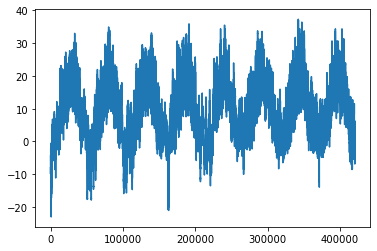

In [7]:
"the plot of temperature (in degrees Celsius) over time (zamana gore hava sicakligini cizdirelim)"

from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

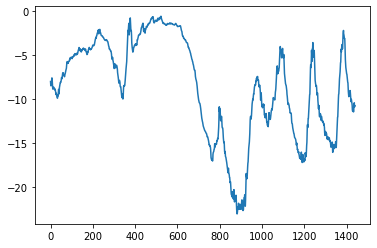

In [8]:
"""
Here is a more narrow plot of the first 10 days of temperature data. 
Because the data is recorded every 10 minutes, you get 144 data points per day.
(ilk 10 gunluk hava sicakligina bakalim, her 10 dakikada bir olcum alindigi icin
bir gunde 144 veri bulunmaktadir.)
"""

plt.plot(range(1440), temp[:1440])

On this plot, you can see daily periodicity, especially evident for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

If you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out.

*Bu sekilde gunluk periyottaki tekrari ozellikle de son 4 gundekini gorebilirsiniz. Ayni zamanda bu 10 gunun soguk bor kis gunune ait olduguna da dikkat ediniz.*

*Eger son birkac aya bakarak bir sonraki ayin ortalama hava sicakligini tahmin ediyor olsaydiniz, yillik bazda guvenilir bir periyodiklik bulundugundan problem daha kolay olurdu. Ama son birkac gune bakinda bu durum daha kaotik oluyor. Gunluk periyotta bu zaman serisi tahmin edilebilir mi?*

### **Preparing the data**

The exact formulation of the problem will be as follows: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps? You’ll use the following parameter values:

- lookback = 720—Observations will go back 5 days.
- steps = 6—Observations will be sampled at one data point per hour.
- delay = 144—Targets will be 24 hours in the future.

*Problemin tam formulasyonu soyledir. loocback zaman adimi (bir zaman adimi 10 dakika) kadar geriye bakarak steps zaman adiminda orneklenmis veriden delay zaman adimi sonrasindaki hava sicakligi tahmin edilebilir mi? Bunu icin asagidaki parametreler kullanilacak.*

- *loockback = 720 (son 5 gunluk verideki gozlemlere bakilacak.)*
- *steps = 6 (gozlemler saatte bir veri olarak alinacak)*
- *delay = 144 (hedef 24 saat sonrasi olacak)*

To get started, you need to do two things:

- Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.
*(verileri sinir aginin kullanabilecegi formata duzenlemek. Veriler zaten sayisal oldugundan vektorel hale getirilmeyecek. ZAman serisindeki her veri farkli aralikta orneklenmis. Bu verileri normalize edeceksiniz.)*

- Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data.
*(Bir Python uretecei yazacaksiniz. Bu uretec ondalik verileri alacak ve yiginlar halinde gecmis veriyi ve hedef hava sicakligini geri dondurecek. Vri setinde gereginden fazla veri bulundugundan en basindan tum veriyi hafizada tutmak yerine, uretec, veriyi ozgun veride kullanacagi zaman olusturacak.)*



You’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. You’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.

Verilerin ortalamalarini cikartip standart sapmasinda bolerek normalize edeceksiniz. Ilk 200000 ornegi egitim verisi olarak kullanacaginizdan ortalama ve standart sapmayi bu bolumde hesaplayacaksiniz.

In [9]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

Data Generator : It yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:

- data—The original array of floating-point data, which you normalized in listing 6.32.
- lookback—How many timesteps back the input data should go.
- delay—How many timesteps in the future the target should be.
- min_index and max_index—Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
- shuffle—Whether to shuffle the samples or draw them in chronological order.
- batch_size—The number of samples per batch.
- step—The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour.

Samples ve targets seklinde demetler geri donecek olan bir fonksiyon tanimliyoruz. Her samples, girdi verisini ve bu veriye ait targets hedefleri bulunduran dizi bulunduruyor.

- data : ondalik verilerden olusan, normalize ettigimiz ozgun veriler
- lookback : kac zaman adim geriye bakilacagi
- delay : hedefin kac zaman adimi sonra olacagi
- min_index and max_index : data dizisindeki zaman adimlarini sinirlayacak en kucuk ve en buyuk indeks degeri. Bu dogrulama ve test veri setlerini ayirabilmek icin kullanilacak.
- shuffle : Verilerin kronolojik sirada mi yoksa rastgele mi olacagi
- batch_size : yiginaki ornek sayisi
- step : verileri ornekleme periyodu

In [11]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Now, let’s use the abstract generator function to instantiate three generators: one for training, one for validation, and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

Simdi generator metodunu kullanarak uc uretec uretecegiz. Biri egitim, digeri dogrulama ve sonuncusu da test icin. Her biri farkli zaman bolumlerine bakacak. Ilk 200000 zaman adimi egitim uretici tarafindan devam eden 100000 zaman adimi dogrulama icin ve kalaniysa test icin kullanilacak.

In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size # dogrulama veri seti kac adimda gecilecek

test_steps = (len(float_data) - 300001 - lookback) // batch_size # tum test seti kac adimda gorulecek

### **A basic machine-learning approach**

In the same way that it’s useful to establish a common-sense baseline before trying machine-learning approaches, it’s useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. You use MAE as the loss.

Herhangi bir makine ogrenmesi modeli gelistirmeden once akil yurutmeyi kullandiginiz gibi hesaplama karmasikligi yuksek modeller (mesela RNN) kullanmadan once de basit makine ogrenmesi modelleri (tamamen bagli aglar gibi) kullanmak iyi olacaktir. Boylece daha karmasik seyler yapmanin mantikli ve gercek getirisi olup olmadigini gorebilirsiniz.

Asagida kod obeyi veriyi duzlestirip iki Dense katmanla tamamen bagli bir model olusturulmasini gosteriyor. Elinizde bir baglanim problemi oldugu icin son katmanda aktivasyon fonskiyonu kullanmamaya dikkat edin. Kayip fonksiyonu olarak MAE kullanin.

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 12s 23ms/step - loss: 1.2200 - val_loss: 0.6179
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.4231 - val_loss: 0.3428
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2903 - val_loss: 0.3358
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2660 - val_loss: 0.3108
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2527 - val_loss: 0.3250
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2449 - val_loss: 0.3217
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2380 - val_loss: 0.3210
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2330 - val_loss: 0.3584
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2284 - val_loss: 0.3254
Epoch 

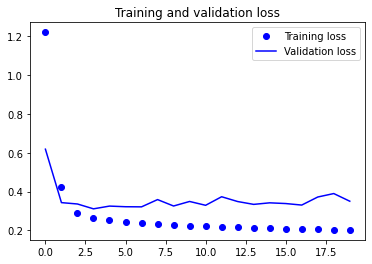

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### **A first recurrent baseline**

Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the LSTM layer introduced in the previous section, we will use the GRU layer, developed by Cho et al. in 2014. GRU layers (which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

Ilk tamamen bagli yaklasim cok da basarili degildi. Ancak bu, makine ogrenmesinin bu probleme uygun olmadigi anlamina gelmez. Onceki yaklasim zaman serisini duzlestirmis ve zamansal nosyonu ortadan kaldirmisti. Simdi veriye oldugu gibi yani nedensellik ve siralamanin onemli oldugu bir dizi olarak bakalim. Yinelemeli dizi isleme modeli olusturacaksiniz - verilerin ilk modelde goz ardi edilen siralamasini ve iliskisini ortaya cikaran bir yaklasim oldugundan, boyle bir dizi verisiyle mukemmel uyum icinde olacaktir.

Onceden tanittigimiz LTSM katmani yerine 2014 yiinda gelistirilen GRU katmanini kullanacaksiniz. Kapali yinelemeli katmanlar (GRU) LSTM'ler ile ayni prensipleri kullanirlar ama daha az maliyetle calisirlar (LSTM'ler ile ayni gosterim gucune sahip olmayabilirler) Hesaplama karmasikligi ve gosterim gucu dengesi makine ogrenmesinde surekli karsiniza cikacaktir.

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3037 - val_loss: 0.2791
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2853 - val_loss: 0.2648
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2777 - val_loss: 0.2678
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2745 - val_loss: 0.2685
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2689 - val_loss: 0.2645
Epoch 6/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2652 - val_loss: 0.2722
Epoch 7/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2595 - val_loss: 0.2687
Epoch 8/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2573 - val_loss: 0.2780
Epoch 9/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2506 - val_loss: 0.2667
Epoch 10/20
500/500 [==============================] - 22s 44ms/step - loss: 0.247

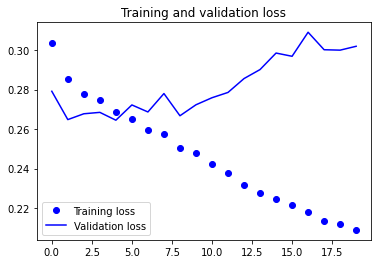

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

Daha iyi. Simdi belirgin olarak en temel akil yuruten modeli yeniyor ve makine ogrenmesinin degerini ve dizileri duzlestiren yaklasim karsi yinelemeli katmanlarin gucunu gosteriyor.

Asiri ogrenmenin basladigini goruyoruz.

### **Using recurrent dropout to fight overfitting¶**

It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many epochs.

Egitim ve dogrulama egrileriniz asiri uydurdugunuzun kanitidir. Birkac epoktan sonra egitim ve dogrulama kayiplari birbirinden farklilasiyor ve uzaklasiyor. Bu fenomenle mucadelede kullanilan klasik tekniklere asinasiniz. Katmanin girdisinden bazi elemanlari rastgele sifirlayip hasbelkader iliskilerin ogrenilmesini engelleyen iletim sonumu. Ama yinelemeli katmanlara iletim sonumunu uygulamak basit islem degildir. Uzun bir sure iletim sonumunu yinelemeli katmanlarda kullanmanin duzenlilestirmeye katki saglamak yerine ogrenmeyi engelledigi biliniyordu. 2015 yilinda Basyesci derin ogrenme konulu dotora tezi calismasi kapsaminda Yarin Gal, yinelemeli katmanlara iletim sonumu uygulamanin bir yolunu buldu. Her zaman adiminda rastgele iletim sonumu uygulamak yerine, rastgele secilen iletim sonumu maskesini her zaman adiminda uygulamak. DAhasi GRU ve LSTM gibi katmanlarinin kapali kullaniminda gosterimleri duzenlestirmek icin zamanda sabit bir iletim sonumu maskesini yinelemeli katmanin ic aktivasyonlarina uygulamasi gerekir.Ayni iletim sonumu maskesini her zaman adiminda uygulamak zaman icerisinde ogrenme hatasinin geriye yayilabilmesini saglar. Ancak zamanda rastgele iletim sonumu maskesi kullanmak hata sinyalinin geriye yayilmasini engelledigi icin ogrenmeye zarar verir.

Yarin Gal, arastirmalarini Keras kullanarak yapti ve bu mekanizmanin Keras katmanlarina dogrudan uygulanmasinda yardimci oldu. Kerastaki her yinelemeli katman iletim sonumuyle ilgili iki parametre sunmaktadir.
dropout iletim sonum oranini ondalik degeri ve 
recurrent_droput yinelemeli karmanlarin iletim sonum orani.
Simdi de iletim sonumu ve yinelemeli iletim sonumu GRU katmaninda ekleyelim ve asiri uydurmaya etkisini gorelim. Iletim sonumuyle duzenlilestirilmis bir agin yakinsamasini zaman alacagindan iki kat fazla epokla egiteceksiniz.

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     #recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
100/100 [==============================] - 108s 1s/step - loss: 0.3574 - val_loss: 0.2845
Epoch 2/10
100/100 [==============================] - 108s 1s/step - loss: 0.3203 - val_loss: 0.2930
Epoch 3/10
100/100 [==============================] - 108s 1s/step - loss: 0.3131 - val_loss: 0.2817
Epoch 4/10
100/100 [==============================] - 108s 1s/step - loss: 0.3105 - val_loss: 0.2787
Epoch 5/10
100/100 [==============================] - 107s 1s/step - loss: 0.3107 - val_loss: 0.2891
Epoch 6/10
100/100 [==============================] - 108s 1s/step - loss: 0.3070 - val_loss: 0.2846
Epoch 7/10
100/100 [==============================] - 109s 1s/step - loss: 0.3093 - val_loss: 0.2841
Epoch 8/10
100/100 [==============================] - 109s 1s/step - loss: 0.3059 - val_loss: 0.2785
Epoch 9/10
100/100 [==============================] - 108s 1s/step - loss: 0.3032 - val_loss: 0.2802
Epoch 10/10
100/100 [==============================] - 130s 1s/step - loss: 0.2998 - val_lo

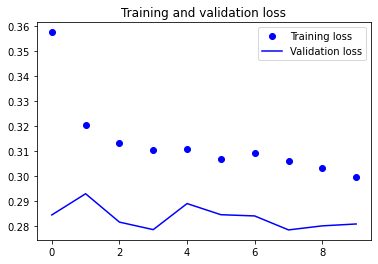

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best scores are not much lower than they were previously.

30 epok yapmamiza ragmen agimizda asiri uydurma problemi yok, ancak daha dengeli degerlendirme sonuclarina ulasmis olsak da en iyi sonucumuz bir onceki calisamadan pek de iyi degil.

### **Stacking recurrent layers**

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True:

Asiri uydurmadan kurtuldunuz ama hala performansi yeterince atiramamadiginiz icin agin kapasitesini artirmayi dusunmelisiniz. Makine ogrenmesi is akisini hatirlayin. Asiri uydurma ana engel olana kadar agin kapasitesini aritirin (iletim sonumu kullanimi gibi asiri uydurmaya karsi onlemleri aldiginiz dusunulerek) Cok agir sekilde uydurmadiginiz surece dusuk kapasitlesi calistiginizi dusunebilirsiniz.

Agin kapasitesini arttirmak katmanlardaki birimleri veya katmanlarin sayisini arttirarak saglanabilir. Yinelemeli katmanlarin ust ute kullanimi, daha guclu yinelemeli aglarin olusturulmasi icin kulanilan klasik bir yoldur. Ornegin Google'in diller arasi ceviri yapan sistemine gucunu yedi katli LSTM katmanlari veriyor.

0Keras'ta yinelemeli katmanlari ust uste kullanirken her ara katman cikti olarak son zaman adimini vermek yerine tum dizyi (3B tensor) vermelidir. Bunu return_sequences=True ile yapabilirsiniz.

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     #recurrent_dropout=0, # ornekte 0.5 olarak belirtiliyor ama gpu bile asiri yavasliyor
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, 
                     #activation='relu', # activation relu olunca da yavasliyor, 
                     dropout=0.1))
                     #recurrent_dropout=0))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

"https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1"
"yavaslama sorunu hakkinda burada bazi bilgiler mevcut"

Epoch 1/40
500/500 [==============================] - 17s 33ms/step - loss: 0.3133 - val_loss: 0.2711
Epoch 2/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2939 - val_loss: 0.2656
Epoch 3/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2828 - val_loss: 0.2677
Epoch 4/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2736 - val_loss: 0.2621
Epoch 5/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2659 - val_loss: 0.2687
Epoch 6/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2567 - val_loss: 0.2854
Epoch 7/40
500/500 [==============================] - 15s 31ms/step - loss: 0.2481 - val_loss: 0.2902
Epoch 8/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2383 - val_loss: 0.3040
Epoch 9/40
500/500 [==============================] - 16s 31ms/step - loss: 0.2284 - val_loss: 0.2962
Epoch 10/40
500/500 [==============================] - 16s 32ms/step - loss: 0.218

CuDNN çekirdeği belirli varsayımlarla oluşturulduğundan, bu , yerleşik LSTM veya GRU katmanlarının varsayılanlarını değiştirirseniz katmanın CuDNN çekirdeğini kullanamayacağı anlamına gelir. Örneğin:

- activation işlevini tanh başka bir şeye değiştirme.
- recurrent_activation işlevini sigmoid başka bir şeye değiştirme.
- recurrent_dropout > 0 kullanılması.
- Ayar unroll kuvvetleri LSTM / GRU iç ayrıştırmak için True, için tf.while_loop bir açılmış haline for döngü.
use_bias False olarak ayarlama.
- Giriş verileri kesinlikle doğru şekilde doldurulmadığında maskeleme kullanma (maske kesinlikle doğru doldurulmuş verilere karşılık geliyorsa, CuDNN yine de kullanılabilir. Bu en yaygın durumdur).

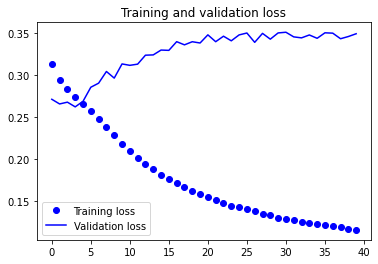

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the added layers does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

- Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss improvement. This does have a non-negligible computational cost, though.
- Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this point.

Iki katman eklemek sonuclari biraz iyilestirdi ama belirgin bir iyilestirme yok. Buradan iki sonuc cikarabilirsiniz.

- Asiri uydurma konusunda sorununuz olmadigi icin katman ekleme ve dogrulama kaybi iyilestirmei icin calisabilirsiniz. Elbette bu durum kacinilmaz olarak hesaplama maliyetini arttiracaktir.
- Yeni katmanlar eklemek yeterince iyilestirmiyor, o zaman bu noktada artik yeni katman eklemeye gerek yok.

### **Using bidirectional RNNs**

The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted along the time dimension (replace the last line with yield samples[:, ::-1, :], targets). Training the same one-GRU-layer network as we used in the first experiment in this section, we get the following results:

*Iki yonlu RNN'ler RNN'lerin bazi gorevlerde daha iyi performans saglayan farkli bir cesididir. Genellikle dogal dil islemede kullanilir -derin ogrenmenin dogal dil islemedeki Isvicre cakisi olarak dusunebilirsiniz.*

*RNN'ler sira ve zaman bagimlidir. Girdi dizisinin sirasi ve rastgele duzenlenmesi veya tersten siralanmasi RNN tarafindan cikarilacak sonuclari degistirir. Dolayisiyla bu, hava sicakligi tahmin problemi gibi siralamanin onemli oldugu problemlerde iyi sonuclar elde etmelerinin ana sebebidir. Iki yonlu RNN'ler RNN'lerin sira bagimliligindan istifade eder. GRU ya da LSTM gibi siradan yinelemeli katmanlardan her biri bir yonde calisan (kronolojik sirada veya tersinde) iki tane katman bulundururlar ve gosterimlerini birlestirirler. Diziyi iki yonde de isleyerek tek yonlu RNN'ler tarafindan goz ardi edilen oruntuleri yakalayabilirler.*

*Bu bolumde gordugunuz RNN katmanlarinin dizileri kronolojik (eskiden yeniye) sirada islemesi sadece bir secimdi. En azindan su ana kadar sorgulamadigimiz bir karardi. Acaba RNN'ler dizileri tersten isleseler sonuclar degisir mi? Bunu bir uygulamada gorelim ve neler degisecek inceleyelim. Yapmaniz gereken tek sey veri ureticinin dizileri ters sirada (yield sample[:,::-1,:],targets satirini yenisiyle degistirerek) donduren bir cesidini yazmak.*

In [27]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [28]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 0.4764 - val_loss: 0.4834
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4516 - val_loss: 0.4646
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.4077 - val_loss: 0.4289
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3609 - val_loss: 0.3692
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3167 - val_loss: 0.3308
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2922 - val_loss: 0.3187
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2811 - val_loss: 0.3081
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2711 - val_loss: 0.3185
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2636 - val_loss: 0.3125
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.260

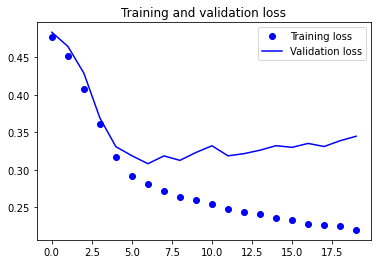

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's try the same trick on the LSTM IMDB example from the previous section:

*Ters sirali GRU akil yurutmeden bile daha kotu sonuclar uretti, bu da kronolojik sirada egitmenin yaklasiminizin basarisi icin onemini gosteriyor. Bu cok mantikli: GRU katmani tahmin uretirken yakin gecmisi uzak gecmisten daha iyi hatirliyor. Kronolojik sirali versiyonunuz tersten siralidan cok daha iyidir. Ama bu dolgal dil isleme gibi her problemde dogru olmayabilir. Bir cumleyi anlamada bir kelimeyi anlamanin onemi genellikle cumle icindeki yerine bagli degildir.Ayni hileyi IMDB orneginde kullanalim.*

In [30]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# dizileri ters sirali olusturma
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 7s 43ms/step - loss: 0.4962 - acc: 0.7656 - val_loss: 0.3870 - val_acc: 0.8568
Epoch 2/10
157/157 [==============================] - 6s 39ms/step - loss: 0.3274 - acc: 0.8749 - val_loss: 0.5343 - val_acc: 0.8098
Epoch 3/10
157/157 [==============================] - 6s 41ms/step - loss: 0.2677 - acc: 0.8997 - val_loss: 0.3656 - val_acc: 0.8776
Epoch 4/10
157/157 [==============================] - 6s 40ms/step - loss: 0.2202 - acc: 0.9205 - val_loss: 0.5569 - val_acc: 0.7474
Epoch 5/10
157/157 [==============================] - 6s 39ms/step - loss: 0.1992 - acc: 0.9302 - val_loss: 0.3756 - val_acc: 0.8364
Epoch 6/10
157/157 [==============================] - 6s 39ms/step - loss: 0.1780 - acc: 0.9380 - val_loss: 0.6859 - val_acc: 0.7340
Epoch 7/10
157/157 [==============================] - 6s 39ms/step - loss: 0.1669 - acc: 0.9408 - val_loss: 0.3676 - val_acc: 0.8580
Epoch 8/10
157/157 [==============================] - 6s 41ms/step - 

We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our hypothesis that, albeit word order does matter in understanding language, which order you use isn't crucial. Importantly, a RNN trained on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and you were born on your last day. In machine learning, representations that are different yet useful are always worth exploiting, and the more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

To instantiate a bidirectional RNN in Keras, one would use the Bidirectional layer, which takes as first argument a recurrent layer instance. Bidirectional will create a second, separate instance of this recurrent layer, and will use one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the IMDB sentiment analysis task:

*Neredeyse kronolojik sirali LTSM ile ayni sonuclari elde ettiniz. Dahasi, metin veri setlerinde koronolojik sira ve tersten kronolojik sira ise yariyor. Her ne kadar kelime sirasi, dogal dil islemede onemli olsa da hangi siralamayi kullandiginizin bor onemi yoktur. Ters siralamayla egitilmis RNN, normal siralamada egitilenden farkli gosterimler ogrenecektir. Ayni gercek hayatta zaman tersten aksaydi oldugunuz gun ilk gununuz, dogdugunuz gun son gununuz olsaydi farkli dusunme modeline sahip olacaganiz gibi. Makine ogrenmesinde farkli oldugu kadar kullanisli gosterimler farklilastikca daha iyi olur. Baktiginiz veriye farkli acilar sinar, bir yaklasimin gozden kacirdigini yakalar ve performansi iyilestirir.*

*Iki yonlu RNN'ler bu dusunceden yola cikarak kronolojik siralama da performansi artirmak icin kullanilir. Girdiye her iki yonden bakarak olasi daha zengin gosterimleri ve kronolojik sirada gozden kacan oruntuleri yakalar.*

*Keras'ta iki yonlu RNN katmani olusturmak icin Bidirectional katmani kullanacaksiniz. Il parametre olarak, kullanacagi yinelemeli katman gonderilir. Bidirectional bu yinelemeli katmanin ayri ikinci bir ornegini olusturur ve birinde kronolojik sirada digerinde ters sirada girdiyi isler. Simdi bunu IMBD setinde deneyelim.*

In [31]:
from keras import backend as K
K.clear_session()

In [32]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 8s 51ms/step - loss: 0.5377 - acc: 0.7363 - val_loss: 0.5101 - val_acc: 0.8186
Epoch 2/10
157/157 [==============================] - 7s 46ms/step - loss: 0.3232 - acc: 0.8787 - val_loss: 0.4005 - val_acc: 0.8614
Epoch 3/10
157/157 [==============================] - 7s 45ms/step - loss: 0.2655 - acc: 0.9010 - val_loss: 0.4933 - val_acc: 0.7726
Epoch 4/10
157/157 [==============================] - 7s 45ms/step - loss: 0.2270 - acc: 0.9175 - val_loss: 0.3329 - val_acc: 0.8838
Epoch 5/10
157/157 [==============================] - 7s 45ms/step - loss: 0.1941 - acc: 0.9319 - val_loss: 0.3078 - val_acc: 0.8798
Epoch 6/10
157/157 [==============================] - 7s 46ms/step - loss: 0.1754 - acc: 0.9375 - val_loss: 0.3406 - val_acc: 0.8706
Epoch 7/10
157/157 [==============================] - 7s 46ms/step - loss: 0.1575 - acc: 0.9445 - val_loss: 0.6030 - val_acc: 0.7822
Epoch 8/10
157/157 [==============================] - 7s 47ms/step - 

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:

*Onceki bolumde gordugumuz normal LSTM'den biraz daha iyi bir performans gosteriyor. Ama daha hizli asiri uydurdugunu gorebilirsiniz ve bu supriz olmamali. Cunku iki yonlu katman kronolojik sirali LSTM nin iki kati parametre kullaniyor. Biraz duzenlilestirmeyle iki yonlu yaklasim bu gorevde daha iyi performans gostermeye adaydir.*

*Simdi de bu yaklasimi hava sicakligi tahmin gorevinde deneyelim.*

In [33]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 14s 29ms/step - loss: 0.2887 - val_loss: 0.2737
Epoch 2/40
500/500 [==============================] - 13s 27ms/step - loss: 0.2730 - val_loss: 0.2839
Epoch 3/40
500/500 [==============================] - 13s 26ms/step - loss: 0.2687 - val_loss: 0.2720
Epoch 4/40
500/500 [==============================] - 13s 26ms/step - loss: 0.2642 - val_loss: 0.2709
Epoch 5/40
500/500 [==============================] - 13s 27ms/step - loss: 0.2556 - val_loss: 0.2721
Epoch 6/40
500/500 [==============================] - 13s 26ms/step - loss: 0.2526 - val_loss: 0.2796
Epoch 7/40
500/500 [==============================] - 13s 26ms/step - loss: 0.2448 - val_loss: 0.2785
Epoch 8/40
500/500 [==============================] - 13s 27ms/step - loss: 0.2370 - val_loss: 0.2753
Epoch 9/40
500/500 [==============================] - 13s 27ms/step - loss: 0.2324 - val_loss: 0.2821
Epoch 10/40
500/500 [==============================] - 14s 27ms/step - loss: 0.224

It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past in this case).

*Bu da normal GRU katmaniyla benzer sonuclar elde ediyor. Neden oldugunu anlamak kolay: Bu gorevde tahmin kapasitesinin yarisi kornolojik agdan yarisiysa bu gorevde basarisiz olan ters sirali agdan geliyor (unutmayin yakin gecmis uzak gexmisten daha onemli bir veri setinde)*

### **Going even further**

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

- Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely suboptimal.
- Adjust the learning rate used by our RMSprop optimizer.
- Try using LSTM layers instead of GRU layers.
- Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger Dense layer or even a stack of Dense layers.
- Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing architectures that are overfitting to the validation set.
As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.

*Hava sicakligi tahmin probleminde deneyebileceginiz daha baska seyler de var:*

- *Ust uste yinelemeli katman yapisinda katmanlardaki birim sayisini degistirin. Su anki secim tamamen rastgele ve muhtemelen de en iyisi degil.*
- *RMSprop algoritmasinin ogrenme oranini degistirin.*
- *GRU yerine LSTM katmani kullanin.*
- *Yinelemeli katmanlarin uzerinde tamamen bagli Dense baglanim katmani kullanin. Hatta ust uste Dense katmanlari kullanin.*
- *En iyi modelinizi test veri setinde calistirmayi unutmayin (dogrulama MAE skoruna gore en iyisini) Aksi halde dogruama veri detine asiri uyduran bir model elde edersiniz. *

### **Wrapping up**

Here's what you should take away from this section:

- As you first learned in Chapter 4, when approaching a new problem, it is good to first establish common sense baselines for your metric of choice. If you don't have a baseline to beat, you can't tell if you are making any real progress.
- Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
- On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.
- To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras recurrent layers, so all you have to do is use the dropout and recurrent_dropout arguments of recurrent layers.
- Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
- Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

Note there are two important concepts that we will not cover in detail here: recurrent "attention", and sequence masking. Both tend to be especially relevant for natural language processing, and are not particularly applicable to our temperature forecasting problem. We will leave them for future study outside of this book.

- *Yeni bir probleme yaklasirken temel bir model ve olcum kriterlerinizi belirlemelisiniz. Eger yeneceginiz bir temel model yoksa gercekten ilerleme kaydedip kaydetmediginizi bilmezsiniz.*
- *Basit modelleri maliyetli modellerden once deneyerek arti cabaya degip degmedigini belirleyin.*
- *Zamansal siranin onemli oldugu problemlerde yinelemeli modeller veriyi duzlestiren modellerden cok daha basarilidir.*
- *Yinelemeli aglarda iletim sonumu kuallanirken, zamanda sabit bir ileti sonumu maskesi ve yinelemeli iletim sonumu maskesi kullanamazsiniz. Keras'ta bunun icin yinelemeli katmanlarda iki parametre kullanilir. dropout ve recurrent_droput*
- *Ust uste RNN'ler tek RNN katmanindan cok daha guclu gosterimler saglarlar. Ancak yuksek maliyetlerinden dolayi her zaman kullanmaya degmeyebilirler. Makine cevirisi gibi karmasik problemlerde kazanimlar getirse de kucuk ve basit problemler icin gereksizdir.*
- *Veriye her iki yonden de bakan iki yonlu RNN'ler dogal dil isleme problemlerinde kullanislidir. Ama yakin gecmisin uzak gecmisten daha onemli oldugu dizi problemlerinde o kadar da iyi degillerdir.*